## Capstone Project 2: 재고 관리를 위한 단기(6개월) 수요 예측 모델 생성

### Part 4. LSTM 모델

### 사용 데이터셋

> Forecasts for Product Demand: Make Accurate Forecasts for Thousands of Different Products
> - FelixZhao. kaggle. https://www.kaggle.com/felixzhao/productdemandforecasting
> - License: GPL 2

### 1. 데이터 준비

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations
import os
import random
import numpy as np
import tensorflow as tf

main_seed = 1

os.environ['PYTHONHASHSEED']=str(main_seed)
random.seed(main_seed)
np.random.seed(main_seed)
tf.random.set_seed(main_seed)

# matplotlib 화질 설정
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [2]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [3]:
from tensorflow.keras.layers import Dropout, Flatten, Dense, LSTM, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [4]:
# 데이터 불러오기
df = pd.read_csv('Historical_Data_After.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head(3)

,product_code,product_category,date,order_demand,year,month,quarter,YM,YQ
0,993,28,2012-01-19,100,2012,1,1,2012-01,2012-1
1,993,28,2012-02-08,100,2012,2,1,2012-02,2012-1
2,993,28,2012-02-22,100,2012,2,1,2012-02,2012-1


In [5]:
day_list = []

def make_month_day(month, last_day):
    global day_list

    # 월 표기를 01로 변경
    if len(str(month)) == 1:
        month = '0'+str(month)

    # 일 표기 추가
    for day in range(1, last_day):
        if len(str(day)) == 1:
            day = '0'+str(day)

        temp_date = year + '-' + str(month) + '-' + str(day)
        day_list.append(temp_date)
        
for year in ['2012', '2013', '2014', '2015', '2016']:
    for month in range(1, 13):
        
        # 31일까지 있는 달
        if month in [1, 3, 5, 7, 8, 10, 12]:
            make_month_day(month, 32)
        
        # 30일까지 있는 달
        elif month in [4, 6, 9, 11]:
            make_month_day(month, 31)
                
        else:
            month = '02'
            
            # 29일까지 있는 달
            if (year == '2012') or (year == '2016'):
                make_month_day(month, 30)
                
            # 28일까지 있는 달
            else:
                make_month_day(month, 29)

day_list = set(day_list)

print(len(day_list))

1827


In [6]:
temp_cat = pd.pivot_table(df, values='order_demand', index=['date'], columns=['product_category'], aggfunc=np.sum).fillna(0)
temp_cat.columns = list(temp_cat.columns)
temp_cat.head(3)

,1,3,5,6,7,8,9,10,11,13,15,17,18,19,20,21,22,23,24,26,28,29,30,31,32,33
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-02,107.0,0.0,3500.0,13000.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,653950.0,0.0,100.0,0.0,0.0,55.0,0.0,0.0,0.0,9000.0,0.0,540.0,0.0
2012-01-03,25.0,0.0,33600.0,72400.0,6952.0,0.0,1576.0,0.0,151.0,0.0,208.0,0.0,19.0,1499806.0,1000.0,917.0,62.0,170.0,1058.0,114.0,8053.0,0.0,18600.0,10.0,36.0,0.0


In [7]:
# 빈 날짜 목록 생성
temp_cat_index = set(temp_cat.index)
need = day_list - temp_cat_index
print(len(need))

# 빈 날짜의 수요량은 0로 채우기
for idx in list(need):
    temp_cat.loc[idx] = 0

temp_cat = temp_cat.sort_index()

print(temp_cat.shape)

147
(1827, 26)


In [8]:
temp_product = pd.pivot_table(df, values='order_demand', index=['date'], columns=['product_code'], aggfunc=np.sum).fillna(0)
temp_product.columns = list(temp_product.columns)
temp_product.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,2132,2133,2134,2135,2136,2137,2138,2139,2140,2141,2142,2143,2144,2145,2146,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0
2012-01-03,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,153.0,0.0,0.0,20.0,0.0,0.0,1164.0,200.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
# 빈 날짜 목록 생성
temp_product_index = set(temp_product.index)
need = day_list - temp_product_index
print(len(need))

# 빈 날짜의 수요량은 0로 채우기
for idx in list(need):
    temp_product.loc[idx] = 0

temp_product = temp_product.sort_index()

print(temp_product.shape)

147
(1827, 2125)


In [10]:
cat_19 = temp_cat[[19]]
cat_19 = cat_19.reset_index()
cat_19.columns = ['date', 'order_demand']

print(cat_19.shape)
cat_19.head()

(1827, 2)


,date,order_demand
0,2012-01-01,0.0
1,2012-01-02,653950.0
2,2012-01-03,1499806.0
3,2012-01-04,626100.0
4,2012-01-05,7458199.0


In [11]:
# lag 생성
for num in range(1, 41):
  cat_19['t-'+str(num)] = cat_19['order_demand'].shift(num)

In [12]:
# 다 nan인 row(맨 위에 있는 row)
cat_19 = cat_19.drop(0).reset_index(drop=True)

In [13]:
# train, validation dataset
train_lag = cat_19[cat_19['date'] < '2016-07-01']
val_lag = cat_19[cat_19['date'] >= '2016-07-01']

In [14]:
train_lag_2015 = train_lag[train_lag['date'] >= '2015-01-01']

In [15]:
# feature matrix, target vector
X_train_lag = train_lag.drop(['date', 'order_demand'], axis=1)
y_train = train_lag['order_demand']

X_train_lag_2015 = train_lag_2015.drop(['date', 'order_demand'], axis=1)
y_train_2015 = train_lag_2015['order_demand']

X_val_lag = val_lag.drop(['date', 'order_demand'], axis=1)
y_val = val_lag['order_demand']

In [16]:
# 확인
print(X_train_lag.shape, y_train.shape)
print(X_train_lag_2015.shape, y_train_2015.shape)
print(X_val_lag.shape, y_val.shape)
X_train_lag.head(3)

(1642, 40) (1642,)
(547, 40) (547,)
(184, 40) (184,)


,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22,t-23,t-24,t-25,t-26,t-27,t-28,t-29,t-30,t-31,t-32,t-33,t-34,t-35,t-36,t-37,t-38,t-39,t-40
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,653950.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1499806.0,653950.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# 결과 정리를 위한 dataframe 생성
result_df = pd.DataFrame({
    'lag': [],
    'only_2015': [],
    'lstm': [],
    'fc': [],
    'mae': [],
    'rmse': []
})
result_df

,lag,only_2015,lstm,fc,mae,rmse


In [18]:
def create_model(time_stpes=39, n_lstm=1, n_fc=1):
  model = Sequential()
  model.add(Reshape((time_stpes, 1), input_shape=(time_stpes,))) # 3차원으로
  
  # lstm layer 추가 (1 ~ n번째)
  for _ in range(0, n_lstm-1):
    model.add(LSTM(
        32,
        activation='relu',
        kernel_initializer=initializers.glorot_uniform(seed=main_seed),
        recurrent_initializer=initializers.orthogonal(seed=main_seed),
        return_sequences=True))
  
  model.add(LSTM(
    32,
    activation='relu',
    kernel_initializer=initializers.glorot_uniform(seed=main_seed),
    recurrent_initializer=initializers.orthogonal(seed=main_seed)))
      
  # fc layer 추가
  for _ in range(1, n_fc+1):
    model.add(Dense(
        32,
        activation='relu',
        kernel_initializer=initializers.glorot_normal(seed=main_seed)))
  

  # output layer
  model.add(Dense(
      1,
      kernel_initializer=initializers.glorot_normal(seed=main_seed)))
  
  model.compile(optimizer='adam',
                loss='mae',
                metrics=['mae', 'mse'])
  return model

In [19]:
order_list = list(permutations([1, 2, 3], 2))
order_list += [(1, 1), (2, 2), (3, 3)]
order_list = sorted(order_list)

### 2. 모델 생성

#### a. 전체 기간 데이터 사용

In [ ]:
for num in range(1, 41):
  print(f'time_steps: {num} --------------')

  for n_lstm, n_fc in order_list:
    print(f'lstm: {n_lstm}개, fc: {n_fc}개')

    # 모델 생성
    reg = KerasRegressor(
        build_fn=create_model,
        time_stpes=num,
        n_lstm=n_lstm,
        n_fc=n_fc,
        batch_size=32,
        epochs=10,
        verbose=0,
        validation_data=(X_val_lag.iloc[:, :num], y_val))
    
    # 파이프라인
    pipeline = make_pipeline(
        SimpleImputer(),
        RobustScaler(),
        reg)

    # 학습
    pipeline.fit(
        X_train_lag.iloc[num-1:, :num],
        y_train[X_train_lag.iloc[num-1:, :num].index])
    
    # 예측
    y_pred = pipeline.predict(X_val_lag.iloc[:, :num])
    
    # 결과 정리
    new_row = {'lag':num,
              'only_2015':0,
               'lstm': n_lstm,
               'fc': n_fc,
              'mae':round(mae(y_val, y_pred), 2),
              'rmse':round(np.sqrt(mse(y_val, y_pred)), 2)}
    result_df = result_df.append(new_row, ignore_index=True)

In [ ]:
result_df.head()

,lag,only_2015,lstm,fc,mae,rmse
0,1.0,0.0,1.0,1.0,2257986.07,2834455.74
1,1.0,0.0,1.0,2.0,2250231.64,2823720.36
2,1.0,0.0,1.0,3.0,2084107.06,2574926.88
3,1.0,0.0,2.0,1.0,2250825.21,2824550.23
4,1.0,0.0,2.0,2.0,2098323.10,2597918.86


#### b. 2015년부터 사용

In [ ]:
for num in range(1, 41):
  print(f'time_steps: {num} --------------')

  for n_lstm, n_fc in order_list:
    print(f'lstm: {n_lstm}개, fc: {n_fc}개')

    # 모델 생성
    reg = KerasRegressor(
        build_fn=create_model,
        time_stpes=num,
        n_lstm=n_lstm,
        n_fc=n_fc,
        batch_size=32,
        epochs=10,
        verbose=0,
        validation_data=(X_val_lag.iloc[:, :num], y_val))
    
    # 파이프라인
    pipeline = make_pipeline(
        SimpleImputer(),
        RobustScaler(),
        reg)

    # 학습
    pipeline.fit(
        X_train_lag_2015.iloc[num-1:, :num],
        y_train[X_train_lag_2015.iloc[num-1:, :num].index])
    
    # 예측
    y_pred = pipeline.predict(X_val_lag.iloc[:, :num])
    
    # 결과 정리
    new_row = {'lag':num,
              'only_2015':1,
               'lstm': n_lstm,
               'fc': n_fc,
              'mae':round(mae(y_val, y_pred), 2),
              'rmse':round(np.sqrt(mse(y_val, y_pred)), 2)}
    result_df = result_df.append(new_row, ignore_index=True)

In [ ]:
result_df.tail()

,lag,only_2015,lstm,fc,mae,rmse
715,40.0,1.0,2.0,2.0,2241566.92,2811820.08
716,40.0,1.0,2.0,3.0,1397793.56,1697856.28
717,40.0,1.0,3.0,1.0,1470953.34,1739975.41
718,40.0,1.0,3.0,2.0,1434417.73,1776386.14
719,40.0,1.0,3.0,3.0,1382423.49,1673628.43


In [ ]:
result_df.to_csv('result_df_0401.csv')

#### c. 결과 확인

In [21]:
# 상위 10개 (rmse가 작은 순)
result_df.sort_values(by='rmse').head(10)

,lag,only_2015,lstm,fc,mae,rmse
189,22.0,0.0,1.0,1.0,1194299.08,1471630.33
297,34.0,0.0,1.0,1.0,1216102.80,1479199.07
225,26.0,0.0,1.0,1.0,1203525.31,1480820.02
180,21.0,0.0,1.0,1.0,1209417.54,1485578.19
216,25.0,0.0,1.0,1.0,1230842.69,1490168.39
270,31.0,0.0,1.0,1.0,1240819.18,1493451.49
288,33.0,0.0,1.0,1.0,1203561.47,1494765.56
209,24.0,0.0,1.0,3.0,1246930.49,1504449.63
211,24.0,0.0,2.0,2.0,1243584.99,1504987.78
185,21.0,0.0,2.0,3.0,1239124.33,1509277.68


In [22]:
# 하위 10개
result_df.sort_values(by='rmse').tail(10)

,lag,only_2015,lstm,fc,mae,rmse
364,1.0,1.0,2.0,2.0,2258066.40,2834555.75
366,1.0,1.0,3.0,1.0,2258069.35,2834560.09
340,38.0,0.0,3.0,2.0,2258146.94,2834661.65
361,1.0,1.0,1.0,2.0,2258160.33,2834678.46
369,2.0,1.0,1.0,1.0,2258167.49,2834687.99
300,34.0,0.0,2.0,1.0,2258173.06,2834695.29
363,1.0,1.0,2.0,1.0,2258178.16,2834701.25
709,39.0,1.0,3.0,2.0,2258183.16,2834707.98
360,1.0,1.0,1.0,1.0,2258194.46,2834722.49
336,38.0,0.0,2.0,1.0,3274742.76,3745629.39


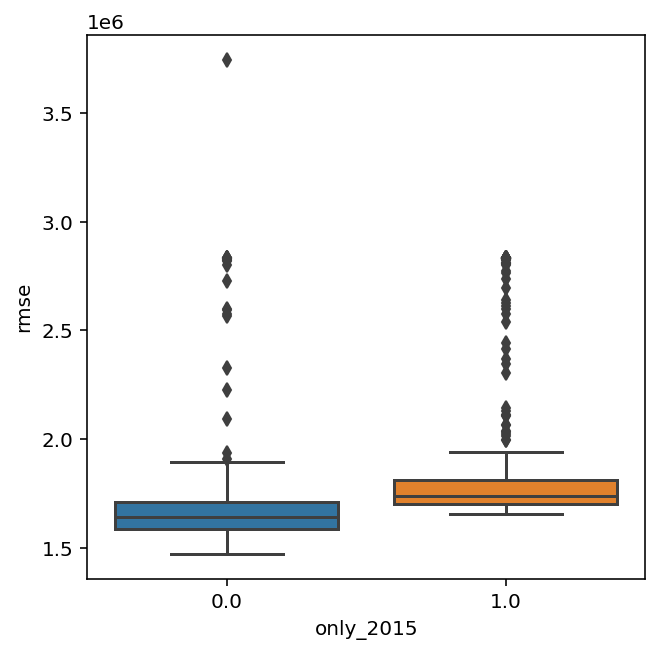

In [23]:
# 전체 데이터 사용과 2015년 데이터만 사용 결과 비교
plt.figure(figsize=(5, 5))
sns.boxplot(data=result_df, x='only_2015', y='rmse')
plt.show();

rmse가 작은 순으로 나열하였을 때, 상위 10개가 모두 전체 기간 데이터를 학습에 사용한 모델이었다. 하지만 전체기간을 사용한 모델의 성능이 최근 데이터만 사용한 모델보다 반드시 좋은 건 아니었다. Lag 일 수에 따라서 최근 데이터만 사용한 모델의 성능이 더 좋은 경우도 있었다만

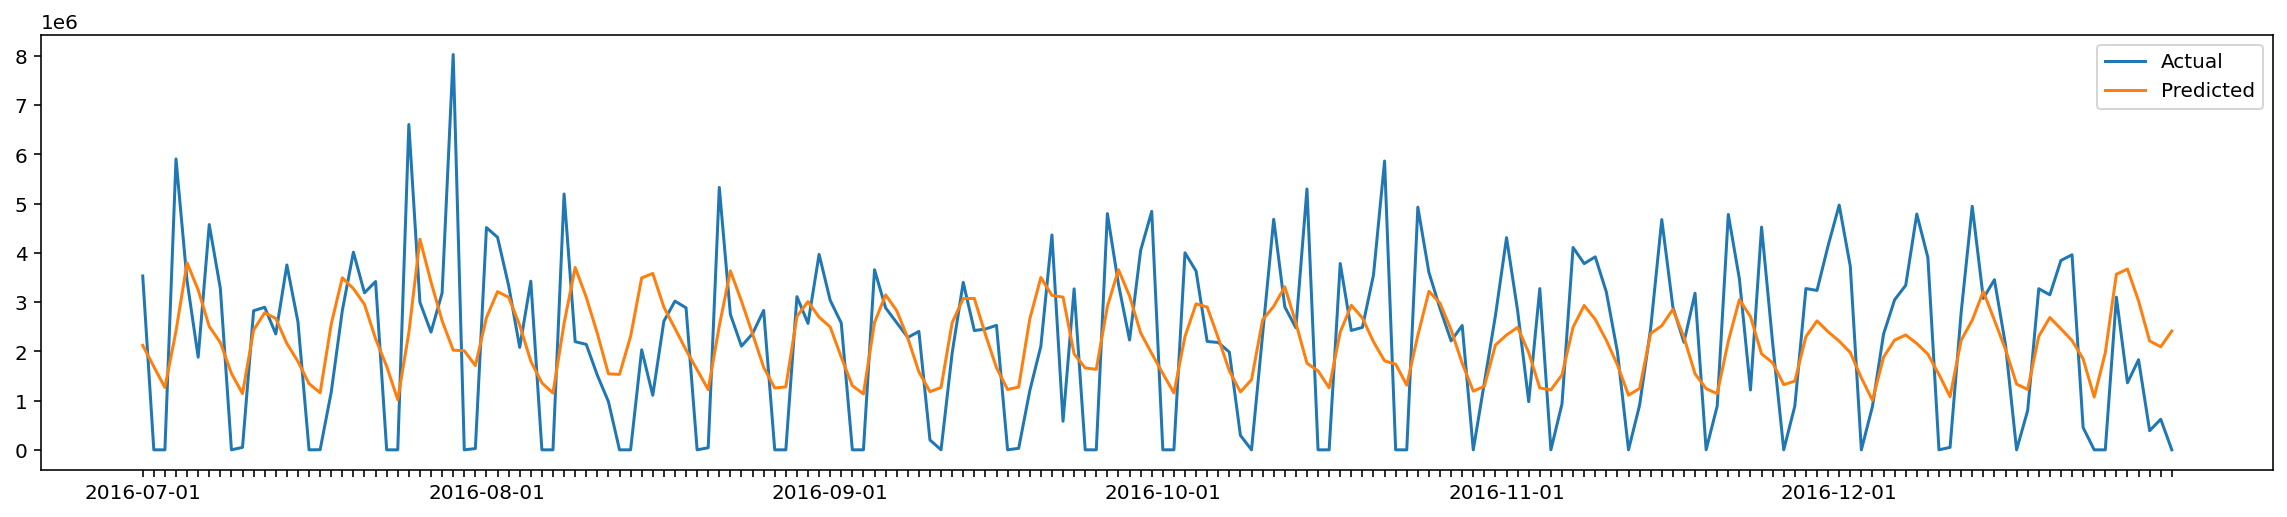

In [ ]:
# 가장 성능이 좋은 모델 (mae가 가장 작은 모델) 예측 결과 시각화
num=22
n_lstm=1
n_fc=1

reg = KerasRegressor(
    build_fn=create_model,
    time_stpes=num,
    n_lstm=n_lstm,
    n_fc=n_fc,
    batch_size=32,
    epochs=10,
    verbose=0,
    validation_data=(X_val_lag.iloc[:, :num], y_val))

# 파이프라인
pipeline = make_pipeline(
    SimpleImputer(),
    RobustScaler(),
    reg)

# 학습
pipeline.fit(
    X_train_lag.iloc[num-1:, :num],
    y_train[X_train_lag.iloc[num-1:, :num].index])

# 예측
y_pred = pipeline.predict(X_val_lag.iloc[:, :num])

# 그래프 그리기
plt.figure(figsize=(20, 4))
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], cat_19[cat_19['date'] >= '2016-07-01']['order_demand'], label='Actual')
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], y_pred, label='Predicted')

labels = [item if item[-2:] == '01' else '' for item in sorted(day_list) if ((item[:4] == '2016') and (item[5:7] >= '07'))]
plt.xticks(cat_19[cat_19['date'] >= '2016-07-01']['date'], labels)
plt.legend()

plt.show();

### 4. 하이퍼 파라미터 튜닝

가장 mae가 낮았던 Lag 22일과 전체 데이터를 학습에 사용한 모델을 하이퍼 파라미터 튜닝하여 성능을 개선해 보았다.

In [24]:
# train, validation set 재정의

num = 22
X_train_22 = X_train_lag.iloc[num-1:, :num]
y_train_22 = y_train[X_train_lag.iloc[num-1:, :num].index]
X_val_22 = X_val_lag.iloc[:, :num]
y_val_22 = y_val

In [25]:
# 확인
print(X_train_22.shape, y_train_22.shape)
X_train_22.head(3)

(1621, 22) (1621,)


,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22
21,10600.0,200.0,1974593.0,2426764.0,2191226.0,2687379.0,4210819.0,0.0,0.0,3247926.0,2261411.0,2660939.0,4023400.0,1118025.0,955000.0,0.0,3452875.0,7458199.0,626100.0,1499806.0,653950.0,0.0
22,2190053.0,10600.0,200.0,1974593.0,2426764.0,2191226.0,2687379.0,4210819.0,0.0,0.0,3247926.0,2261411.0,2660939.0,4023400.0,1118025.0,955000.0,0.0,3452875.0,7458199.0,626100.0,1499806.0,653950.0
23,1935154.0,2190053.0,10600.0,200.0,1974593.0,2426764.0,2191226.0,2687379.0,4210819.0,0.0,0.0,3247926.0,2261411.0,2660939.0,4023400.0,1118025.0,955000.0,0.0,3452875.0,7458199.0,626100.0,1499806.0


In [26]:
print(X_val_22.shape, y_val_22.shape)
X_val_22.head(3)

(184, 22) (184,)


,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22
1642,5817902.0,1961019.0,2152456.0,4581440.0,0.0,100000.0,685201.0,3481061.0,3078208.0,3828421.0,4294075.0,107600.0,0.0,2342028.0,1882308.0,1684213.0,2686727.0,3316681.0,100000.0,0.0,2883302.0,2837548.0
1643,3531523.0,5817902.0,1961019.0,2152456.0,4581440.0,0.0,100000.0,685201.0,3481061.0,3078208.0,3828421.0,4294075.0,107600.0,0.0,2342028.0,1882308.0,1684213.0,2686727.0,3316681.0,100000.0,0.0,2883302.0
1644,0.0,3531523.0,5817902.0,1961019.0,2152456.0,4581440.0,0.0,100000.0,685201.0,3481061.0,3078208.0,3828421.0,4294075.0,107600.0,0.0,2342028.0,1882308.0,1684213.0,2686727.0,3316681.0,100000.0,0.0


#### a. Optimizer

In [27]:
def create_model(optimizer='adam'):
  model = Sequential()
  model.add(Reshape((22, 1), input_shape=(22,)))
  
  model.add(LSTM(
      32,
      activation='relu',
      kernel_initializer=initializers.glorot_uniform(seed=main_seed),
      recurrent_initializer=initializers.orthogonal(seed=main_seed)))

  model.add(Dense(
      32,
      activation='relu',
      kernel_initializer=initializers.glorot_normal(seed=main_seed)))
  
  # output layer
  model.add(Dense(
      1,
      kernel_initializer=initializers.glorot_normal(seed=main_seed)))
  
  model.compile(optimizer=optimizer,
                loss='mse',
                metrics=['mae', 'mse'])
  return model

In [28]:
# 모델 생성
reg = KerasRegressor(
    build_fn=create_model,
    batch_size=32,
    epochs=10,
    verbose=0)

# 파이프라인
lstm_hyper = Pipeline([("imputer", SimpleImputer()), 
                       ('scaler', RobustScaler()), 
                       ("reg", reg)])

# 사용할 하이퍼 파라미터
dists = {'reg__optimizer': ['rmsprop', 'adagrad', 'adadelta', 'adam', 'nadam']}

# cv
cv = TimeSeriesSplit(n_splits=5)

# GridSearchCV
reg_lstm_hyper = GridSearchCV(
    estimator = lstm_hyper, 
    param_grid=dists,
    cv=cv, 
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1)

reg_lstm_hyper.fit(X_train_22, y_train_22);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.3min finished


In [29]:
# 결과 확인
print('best hyper-parameter: ', reg_lstm_hyper.best_params_)

best hyper-parameter:  {'reg__optimizer': 'adam'}


Optimizer는 rmsprop, adagrad, adadelta, adam, nadam 중에서 adam을 사용하는 게 가장 rmse가 작았다.

In [30]:
# cv 결과 확인
pd.DataFrame(reg_lstm_hyper.cv_results_).sort_values(by='rank_test_score').head().T

,3,4,0,1,2
mean_fit_time,5.63958,6.1675,5.77418,5.44451,5.27536
std_fit_time,1.44167,1.38591,1.21788,1.57827,1.36639
mean_score_time,0.327357,0.310479,0.368081,0.33148,0.344035
std_score_time,0.0258137,0.057635,0.0457036,0.0201204,0.029732
param_reg__optimizer,adam,nadam,rmsprop,adagrad,adadelta
params,{'reg__optimizer': 'adam'},{'reg__optimizer': 'nadam'},{'reg__optimizer': 'rmsprop'},{'reg__optimizer': 'adagrad'},{'reg__optimizer': 'adadelta'}
split0_test_score,-1.70299e+06,-1.65375e+06,-1.98343e+06,-2.72219e+06,-2.72219e+06
split1_test_score,-1.82319e+06,-1.75444e+06,-1.7747e+06,-1.86481e+06,-3.00865e+06
split2_test_score,-1.64583e+06,-1.74402e+06,-1.84061e+06,-1.86656e+06,-3.01869e+06
split3_test_score,-1.71235e+06,-1.8218e+06,-1.94606e+06,-1.92991e+06,-3.1772e+06


#### b. Learning Rate

In [31]:
def create_model(
    learning_rate=0.001,
    lstm_node=32,
    lstm_activation='relu',
    fc_node=32,
    fc_activation='relu',
    dropout_rate=0):
  model = Sequential()
  model.add(Reshape((22, 1), input_shape=(22,)))
  
  model.add(LSTM(
      lstm_node,
      activation=lstm_activation,
      kernel_initializer=initializers.glorot_uniform(seed=main_seed),
      recurrent_initializer=initializers.orthogonal(seed=main_seed)))

  model.add(Dense(
      fc_node,
      activation=fc_activation,
      kernel_initializer=initializers.glorot_normal(seed=main_seed)))
  
  model.add(Dropout(dropout_rate, seed=main_seed))
  
  # output layer
  model.add(Dense(
      1,
      kernel_initializer=initializers.glorot_normal(seed=main_seed)))
  
  
  # optimizer
  optimizer = optimizers.Adam(
      learning_rate=learning_rate)
  
  model.compile(optimizer=optimizer,
                loss='mse',
                metrics=['mae', 'mse'])
  return model

In [32]:
# 모델 생성
reg = KerasRegressor(
    build_fn=create_model,
    batch_size=32,
    epochs=10,
    verbose=0)

# 파이프라인
lstm_hyper = Pipeline([("imputer", SimpleImputer()), 
                       ('scaler', RobustScaler()), 
                       ("reg", reg)])

# 사용할 하이퍼 파라미터
dists = {'reg__learning_rate': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]}


# cv
cv = TimeSeriesSplit(n_splits=5)

# GridSearchCV
reg_lstm_hyper = GridSearchCV(
    estimator = lstm_hyper, 
    param_grid=dists,
    cv=cv, 
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1)

reg_lstm_hyper.fit(X_train_22, y_train_22);

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


In [33]:
# 결과 확인
print('best hyper-parameter: ', reg_lstm_hyper.best_params_)

best hyper-parameter:  {'reg__learning_rate': 0.001}


In [34]:
# cv 결과 확인
pd.DataFrame(reg_lstm_hyper.cv_results_).sort_values(by='rank_test_score').head().T

,3,2,4,5,1
mean_fit_time,5.1073,5.13325,5.06484,5.01989,5.13871
std_fit_time,1.47545,1.38854,1.13151,1.18663,1.3472
mean_score_time,0.323593,0.323169,0.325372,0.287783,0.329557
std_score_time,0.0392418,0.0245884,0.0338291,0.0566552,0.0119834
param_reg__learning_rate,0.001,0.0001,0.01,0.1,1e-05
params,{'reg__learning_rate': 0.001},{'reg__learning_rate': 0.0001},{'reg__learning_rate': 0.01},{'reg__learning_rate': 0.1},{'reg__learning_rate': 1e-05}
split0_test_score,-1.77159e+06,-2.72219e+06,-2.72217e+06,-2.72218e+06,-2.72219e+06
split1_test_score,-1.8009e+06,-3.00865e+06,-3.00865e+06,-3.00824e+06,-3.00865e+06
split2_test_score,-1.60113e+06,-2.91798e+06,-3.01868e+06,-3.01864e+06,-3.01869e+06
split3_test_score,-1.70564e+06,-1.92978e+06,-3.17475e+06,-3.17715e+06,-3.1772e+06


Adam optimizer의 learning rate을 0.001로 했을 때의 성능이 가장 좋았다.

#### c. LSTM 레이어 노드 수

In [35]:
# 모델 생성
reg = KerasRegressor(
    build_fn=create_model,
    batch_size=32,
    learning_rate=0.001,
    epochs=10,
    verbose=0)

# 파이프라인
lstm_hyper = Pipeline([("imputer", SimpleImputer()), 
                       ('scaler', RobustScaler()), 
                       ("reg", reg)])

# 사용할 하이퍼 파라미터
dists = {'reg__lstm_node': [8, 16, 32, 64, 128, 256, 512]}


# cv
cv = TimeSeriesSplit(n_splits=5)

# GridSearchCV
reg_lstm_hyper = GridSearchCV(
    estimator = lstm_hyper, 
    param_grid=dists,
    cv=cv, 
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1)

reg_lstm_hyper.fit(X_train_22, y_train_22);

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  7.8min finished


In [36]:
# 결과 확인
print('best hyper-parameter: ', reg_lstm_hyper.best_params_)

best hyper-parameter:  {'reg__lstm_node': 128}


In [37]:
# cv 결과 확인
pd.DataFrame(reg_lstm_hyper.cv_results_).sort_values(by='rank_test_score').head().T

,4,2,3,1,6
mean_fit_time,10.5162,5.11852,6.35482,4.83977,109.796
std_fit_time,3.7952,1.35299,2.05716,1.08461,46.0314
mean_score_time,0.389248,0.381011,0.359882,0.32041,1.18248
std_score_time,0.031071,0.143152,0.0363494,0.0158115,0.3748
param_reg__lstm_node,128,32,64,16,512
params,{'reg__lstm_node': 128},{'reg__lstm_node': 32},{'reg__lstm_node': 64},{'reg__lstm_node': 16},{'reg__lstm_node': 512}
split0_test_score,-1.72154e+06,-1.68158e+06,-1.71259e+06,-1.90873e+06,-2.68783e+06
split1_test_score,-1.66604e+06,-1.74817e+06,-1.78278e+06,-1.83994e+06,-1.82747e+06
split2_test_score,-1.43781e+06,-1.64316e+06,-1.5891e+06,-1.8192e+06,-1.78972e+06
split3_test_score,-1.68027e+06,-1.65767e+06,-1.74825e+06,-1.80843e+06,-1.67637e+06


LSTM의 노드 수는 8, 16, 32, 64, 128, 256, 512 중에서 128로 했을 때가 가장 성능이 좋았다.

#### d. FC(Fully-Connected) 레이어 노드 수

In [39]:
# 모델 생성
reg = KerasRegressor(
    build_fn=create_model,
    batch_size=32,
    learning_rate=0.001,
    lstm_node=128,
    epochs=10,
    verbose=0)

# 파이프라인
lstm_hyper = Pipeline([("imputer", SimpleImputer()), 
                       ('scaler', RobustScaler()), 
                       ("reg", reg)])

# 사용할 하이퍼 파라미터
dists = {'reg__fc_node': [8, 16, 32, 64, 128, 256, 512]}


# cv
cv = TimeSeriesSplit(n_splits=5)

# GridSearchCV
reg_lstm_hyper = GridSearchCV(
    estimator = lstm_hyper, 
    param_grid=dists,
    cv=cv, 
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1)

reg_lstm_hyper.fit(X_train_22, y_train_22);

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  3.3min finished


In [40]:
# 결과 확인
print('best hyper-parameter: ', reg_lstm_hyper.best_params_)

best hyper-parameter:  {'reg__fc_node': 16}


In [41]:
# cv 결과 확인
pd.DataFrame(reg_lstm_hyper.cv_results_).sort_values(by='rank_test_score').head().T

,1,4,5,3,0
mean_fit_time,10.7161,10.7995,10.7451,10.9016,10.2022
std_fit_time,3.68864,3.82699,4.04056,3.72188,3.64561
mean_score_time,0.452946,0.426163,0.401779,0.412894,0.445185
std_score_time,0.0621729,0.0850739,0.045552,0.041131,0.0578711
param_reg__fc_node,16,128,256,64,8
params,{'reg__fc_node': 16},{'reg__fc_node': 128},{'reg__fc_node': 256},{'reg__fc_node': 64},{'reg__fc_node': 8}
split0_test_score,-1.6457e+06,-1.98015e+06,-1.71215e+06,-1.68475e+06,-1.90433e+06
split1_test_score,-1.80798e+06,-1.6705e+06,-1.66997e+06,-1.66909e+06,-1.73126e+06
split2_test_score,-1.45869e+06,-1.46163e+06,-1.64124e+06,-1.90712e+06,-1.58509e+06
split3_test_score,-1.70503e+06,-1.57927e+06,-1.52145e+06,-1.52609e+06,-1.62117e+06


FC 레이어의 노드 수는 16일 때 가장 좋은 성능을 보였다.

#### e. Batch Size

In [45]:
# 모델 생성
reg = KerasRegressor(
    build_fn=create_model,
    learning_rate=0.001,
    lstm_node=128,
    fc_node=16,
    epochs=10,
    verbose=0)

# 파이프라인
lstm_hyper = Pipeline([("imputer", SimpleImputer()), 
                       ('scaler', RobustScaler()), 
                       ("reg", reg)])

# 사용할 하이퍼 파라미터
dists = {'reg__batch_size': [8, 16, 32, 64, 128, 256]}


# cv
cv = TimeSeriesSplit(n_splits=5)

# GridSearchCV
reg_lstm_hyper = GridSearchCV(
    estimator = lstm_hyper, 
    param_grid=dists,
    cv=cv, 
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1)

reg_lstm_hyper.fit(X_train_22, y_train_22);

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.3min finished


In [46]:
# 결과 확인
print('best hyper-parameter: ', reg_lstm_hyper.best_params_)

best hyper-parameter:  {'reg__batch_size': 32}


In [47]:
# cv 결과 확인
pd.DataFrame(reg_lstm_hyper.cv_results_).sort_values(by='rank_test_score').head().T

,2,0,1,3,4
mean_fit_time,10.5427,22.2184,16.4312,10.109,8.73357
std_fit_time,3.62025,9.36341,6.24972,3.54523,2.8228
mean_score_time,0.439545,0.43076,0.515983,0.409732,0.389248
std_score_time,0.0212654,0.0354945,0.044324,0.0125507,0.0268749
param_reg__batch_size,32,8,16,64,128
params,{'reg__batch_size': 32},{'reg__batch_size': 8},{'reg__batch_size': 16},{'reg__batch_size': 64},{'reg__batch_size': 128}
split0_test_score,-1.72818e+06,-1.70208e+06,-2.12535e+06,-1.83006e+06,-1.89585e+06
split1_test_score,-1.71682e+06,-1.85344e+06,-1.88051e+06,-1.91707e+06,-2.26378e+06
split2_test_score,-1.55348e+06,-1.69933e+06,-1.50657e+06,-1.60404e+06,-1.85747e+06
split3_test_score,-1.57817e+06,-1.72603e+06,-1.62409e+06,-1.71845e+06,-1.80465e+06


Batch size가 32인 경우에 가장 성능이 좋았다.

#### f. LSTM Activation

In [48]:
# 모델 생성
reg = KerasRegressor(
    build_fn=create_model,
    learning_rate=0.001,
    lstm_node=128,
    fc_node=16,
    batch_size=32,
    epochs=10,
    verbose=0)

# 파이프라인
lstm_hyper = Pipeline([("imputer", SimpleImputer()), 
                       ('scaler', RobustScaler()), 
                       ("reg", reg)])

# 사용할 하이퍼 파라미터
dists = {'reg__lstm_activation': [None, 'tanh', 'relu', 'elu', 'selu']}

# cv
cv = TimeSeriesSplit(n_splits=5)

# GridSearchCV
reg_lstm_hyper = GridSearchCV(
    estimator = lstm_hyper, 
    param_grid=dists,
    cv=cv, 
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1)

reg_lstm_hyper.fit(X_train_22, y_train_22);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.3min finished


In [49]:
# 결과 확인
print('best hyper-parameter: ', reg_lstm_hyper.best_params_)

best hyper-parameter:  {'reg__lstm_activation': 'relu'}


In [50]:
# cv 결과 확인
pd.DataFrame(reg_lstm_hyper.cv_results_).sort_values(by='rank_test_score').head().T

,2,4,3,0,1
mean_fit_time,10.4701,10.3272,10.6988,9.99914,11.5147
std_fit_time,3.78635,3.55474,3.71391,3.30392,3.38357
mean_score_time,0.415547,0.370995,0.412218,0.365458,0.794148
std_score_time,0.0488411,0.0813785,0.0484382,0.0244973,0.070823
param_reg__lstm_activation,relu,selu,elu,None,tanh
params,{'reg__lstm_activation': 'relu'},{'reg__lstm_activation': 'selu'},{'reg__lstm_activation': 'elu'},{'reg__lstm_activation': None},{'reg__lstm_activation': 'tanh'}
split0_test_score,-1.75143e+06,-1.6413e+06,-1.61234e+06,-2.1271e+06,-2.72216e+06
split1_test_score,-1.62138e+06,-1.72695e+06,-1.9104e+06,-1.86971e+06,-3.00857e+06
split2_test_score,-1.74912e+06,-1.67142e+06,-1.72324e+06,-3.01868e+06,-3.01853e+06
split3_test_score,-1.50403e+06,-1.60332e+06,-1.79189e+06,-1.91516e+06,-3.17696e+06


LSTM 레이어의 activation은 relu 함수를 사용할 때가 가장 좋은 성능을 보였다.

#### g. FC Activation

In [51]:
# 모델 생성
reg = KerasRegressor(
    build_fn=create_model,
    learning_rate=0.001,
    lstm_node=128,
    fc_node=16,
    batch_size=32,
    lstm_activation='relu',
    epochs=10,
    verbose=0)

# 파이프라인
lstm_hyper = Pipeline([("imputer", SimpleImputer()), 
                       ('scaler', RobustScaler()), 
                       ("reg", reg)])

# 사용할 하이퍼 파라미터
dists = {'reg__fc_activation': [None, 'relu', 'elu', 'selu']}

# cv
cv = TimeSeriesSplit(n_splits=5)

# GridSearchCV
reg_lstm_hyper = GridSearchCV(
    estimator = lstm_hyper, 
    param_grid=dists,
    cv=cv, 
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1)

reg_lstm_hyper.fit(X_train_22, y_train_22);

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.9min finished


In [52]:
# 결과 확인
print('best hyper-parameter: ', reg_lstm_hyper.best_params_)

best hyper-parameter:  {'reg__fc_activation': 'selu'}


In [53]:
# cv 결과 확인
pd.DataFrame(reg_lstm_hyper.cv_results_).sort_values(by='rank_test_score').head().T

,3,1,0,2
mean_fit_time,10.0654,10.6573,10.32,10.54
std_fit_time,2.90243,3.74715,3.72549,3.4678
mean_score_time,0.399588,0.493228,0.428163,0.444312
std_score_time,0.10689,0.0755701,0.0366155,0.0919541
param_reg__fc_activation,selu,relu,None,elu
params,{'reg__fc_activation': 'selu'},{'reg__fc_activation': 'relu'},{'reg__fc_activation': None},{'reg__fc_activation': 'elu'}
split0_test_score,-1.61575e+06,-1.79525e+06,-1.65751e+06,-1.90609e+06
split1_test_score,-1.69705e+06,-1.67465e+06,-1.9198e+06,-1.57855e+06
split2_test_score,-1.46126e+06,-1.5286e+06,-1.51406e+06,-1.65396e+06
split3_test_score,-1.62593e+06,-1.52117e+06,-1.55467e+06,-1.67161e+06


FC 레이어의 activation은 selu 함수를 사용했을 때 가장 성능이 좋았다.

#### h. Dropout Rate

In [54]:
# 모델 생성
reg = KerasRegressor(
    build_fn=create_model,
    learning_rate=0.001,
    lstm_node=128,
    fc_node=16,
    batch_size=32,
    lstm_activation='relu',
    fc_activation='selu',
    epochs=10,
    verbose=0)

# 파이프라인
lstm_hyper = Pipeline([("imputer", SimpleImputer()), 
                       ('scaler', RobustScaler()), 
                       ("reg", reg)])

# 사용할 하이퍼 파라미터
dists = {'reg__dropout_rate': [0, 0.1, 0.2, 0.3, 0.4, 0.5]}

# cv
cv = TimeSeriesSplit(n_splits=5)

# GridSearchCV
reg_lstm_hyper = GridSearchCV(
    estimator = lstm_hyper, 
    param_grid=dists,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1)

reg_lstm_hyper.fit(X_train_22, y_train_22);

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.9min finished


In [55]:
# 결과 확인
print('best hyper-parameter: ', reg_lstm_hyper.best_params_)

best hyper-parameter:  {'reg__dropout_rate': 0.2}


In [56]:
# cv 결과 확인
pd.DataFrame(reg_lstm_hyper.cv_results_).sort_values(by='rank_test_score').head().T

,2,0,1,4,3
mean_fit_time,10.8858,10.584,11.0325,10.8825,11.0135
std_fit_time,3.55522,3.73057,3.7365,3.85144,3.75905
mean_score_time,0.438843,0.434864,0.466166,0.419155,0.428951
std_score_time,0.0385169,0.0303983,0.0564273,0.0492011,0.0656233
param_reg__dropout_rate,0.2,0,0.1,0.4,0.3
params,{'reg__dropout_rate': 0.2},{'reg__dropout_rate': 0},{'reg__dropout_rate': 0.1},{'reg__dropout_rate': 0.4},{'reg__dropout_rate': 0.3}
split0_test_score,-1.65014e+06,-1.74116e+06,-1.87259e+06,-1.89426e+06,-1.68688e+06
split1_test_score,-1.84268e+06,-1.61797e+06,-1.62014e+06,-1.82019e+06,-1.92403e+06
split2_test_score,-1.50939e+06,-1.50104e+06,-1.50707e+06,-1.6818e+06,-1.71588e+06
split3_test_score,-1.58303e+06,-1.67054e+06,-1.5684e+06,-1.64076e+06,-1.82067e+06


Dropout rate은 0.2일 때 가장 성능이 좋았다.

#### i. Epochs

In [57]:
pre_processor = make_pipeline(SimpleImputer(), RobustScaler())

X_train_processed = pre_processor.fit_transform(X_train_22)
X_val_processed = pre_processor.transform(X_val_22)

In [58]:
# 모델 생성
reg = KerasRegressor(
    build_fn=create_model,
    learning_rate=0.001,
    lstm_node=128,
    fc_node=16,
    lstm_activation='relu',
    fc_activation='selu',
    dropout_rate=0.2,
    verbose=0)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=2)

file_path = 'lstm_param.hdf5'

# 가장 좋은 모델 저장
save_best = tf.keras.callbacks.ModelCheckpoint(
  filepath=file_path,
  monitor='val_loss',
  verbose=2,
  save_best_only=True,
  save_weights_only=True,
  mode='auto',
  save_freq='epoch',
  option=None)

reg_history = reg.fit(
    X_train_processed,
    y_train_22,
    batch_size=32,
    epochs=100,
    validation_data=(X_val_processed, y_val_22),
    callbacks=[save_best, early_stop]);


Epoch 00001: val_loss improved from inf to 3734314680320.00000, saving model to lstm_param.hdf5

Epoch 00002: val_loss improved from 3734314680320.00000 to 2882053341184.00000, saving model to lstm_param.hdf5

Epoch 00003: val_loss improved from 2882053341184.00000 to 2618278805504.00000, saving model to lstm_param.hdf5

Epoch 00004: val_loss improved from 2618278805504.00000 to 2495862013952.00000, saving model to lstm_param.hdf5

Epoch 00005: val_loss did not improve from 2495862013952.00000

Epoch 00006: val_loss improved from 2495862013952.00000 to 2272045826048.00000, saving model to lstm_param.hdf5

Epoch 00007: val_loss did not improve from 2272045826048.00000

Epoch 00008: val_loss improved from 2272045826048.00000 to 2110901714944.00000, saving model to lstm_param.hdf5

Epoch 00009: val_loss improved from 2110901714944.00000 to 2037901557760.00000, saving model to lstm_param.hdf5

Epoch 00010: val_loss improved from 2037901557760.00000 to 1896358608896.00000, saving model to 

Epoch 값이 52일 때 mse가 가장 작았으며, 그 후로 epoch 값이 62일 때까지 성능이 개선되지 않아서 학습이 종료되었다.

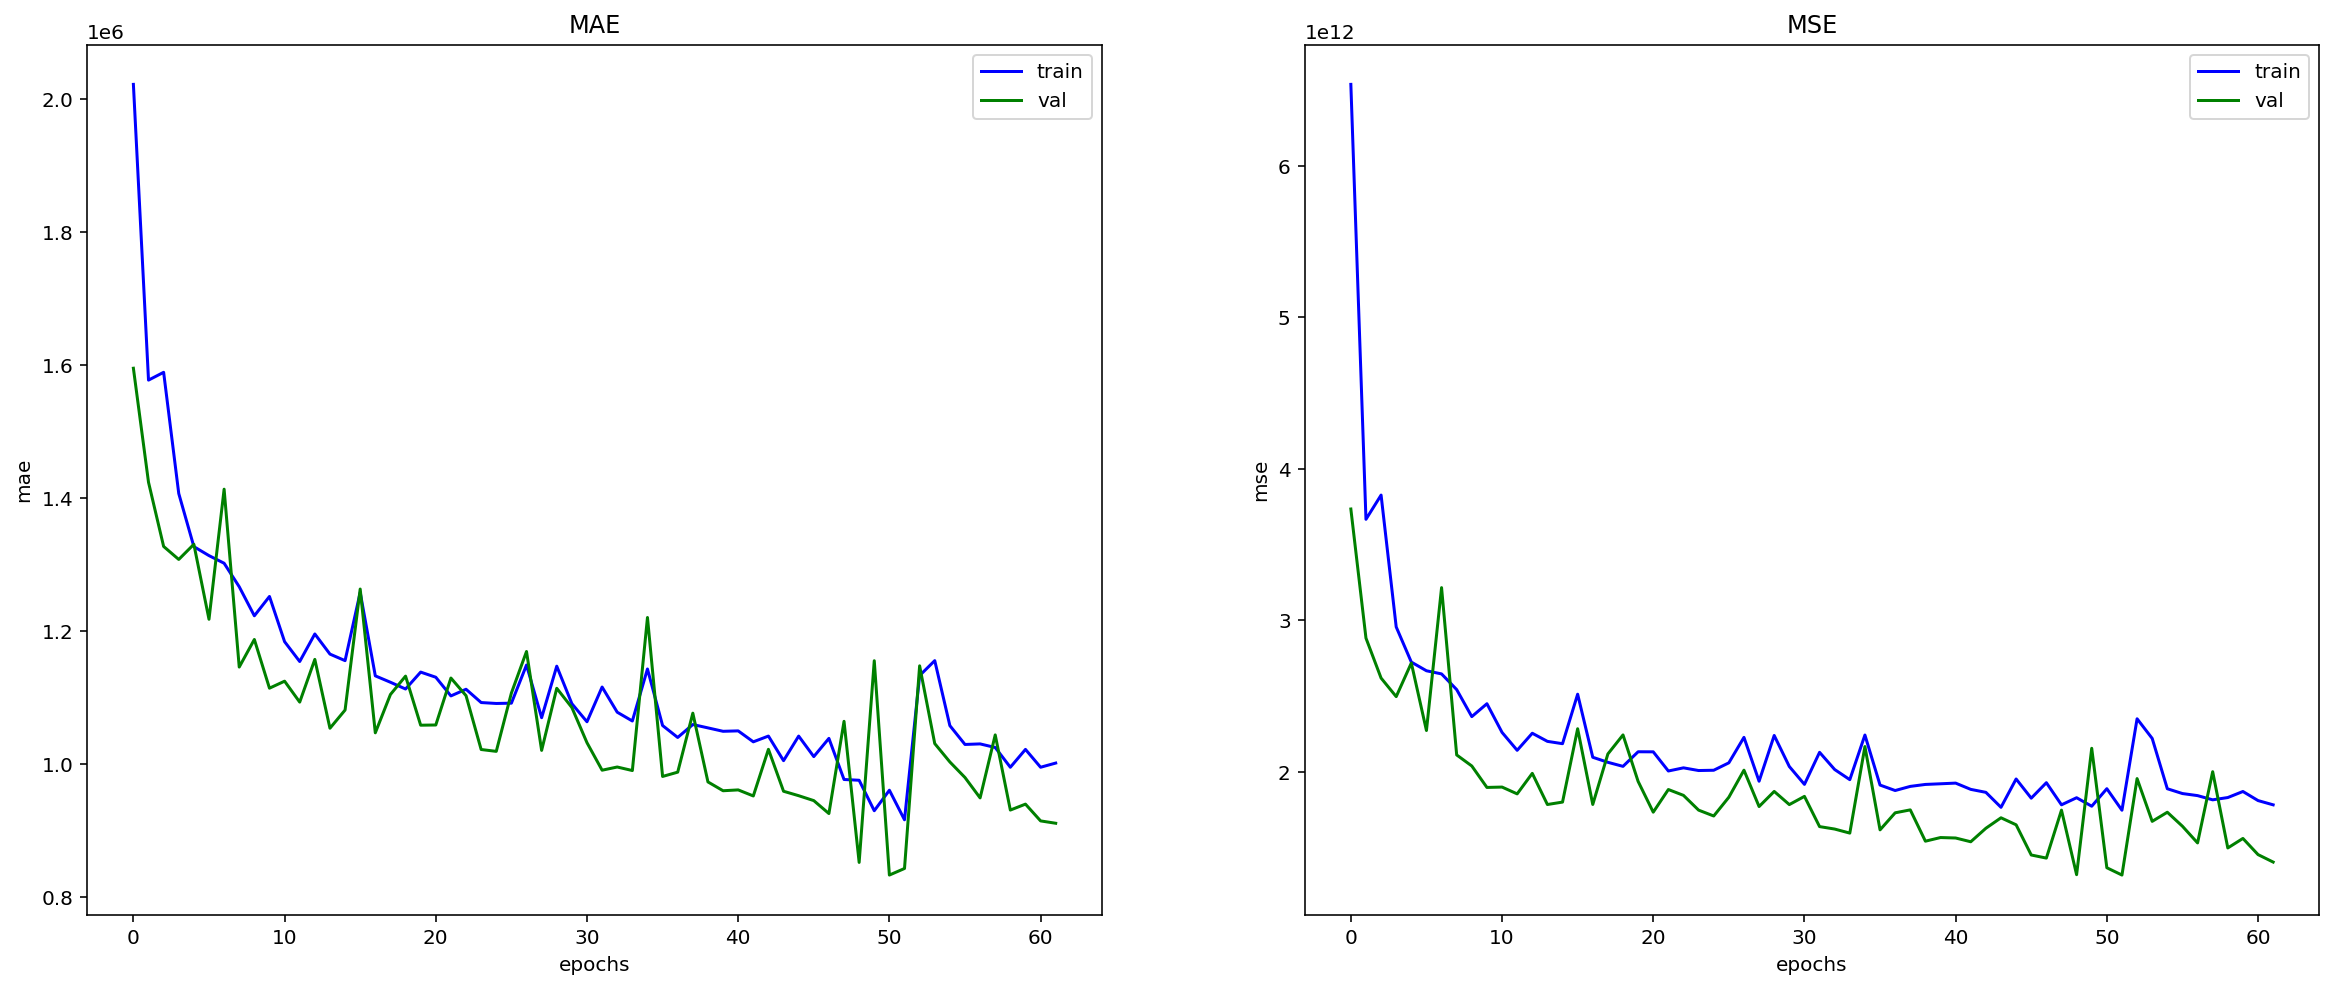

In [59]:
# epoch 값에 따른 mae, mse 변화 시각화
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.plot(reg_history.history['mae'], 'b', label='train')
plt.plot(reg_history.history['val_mae'], 'g', label='val')
plt.title('MAE')
plt.xlabel('epochs')
plt.ylabel('mae')
plt.legend(loc='upper right')

plt.subplot(122)
plt.plot(reg_history.history['mse'], 'b', label='train')
plt.plot(reg_history.history['val_mse'], 'g', label='val')
plt.title('MSE')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend(loc='upper right')

plt.show();

위 그림은 epoch 값에 따른 MAE와 MSE의 변화를 시각화한 것이다.

In [60]:
# 결과 확인
reg.model.load_weights(file_path)
y_pred = reg.predict(X_val_processed)

print('mae :', round(mae(y_val, y_pred), 2))
print('rmse :', round(np.sqrt(mse(y_val, y_pred)), 2))

mae : 842659.64
rmse : 1148008.08


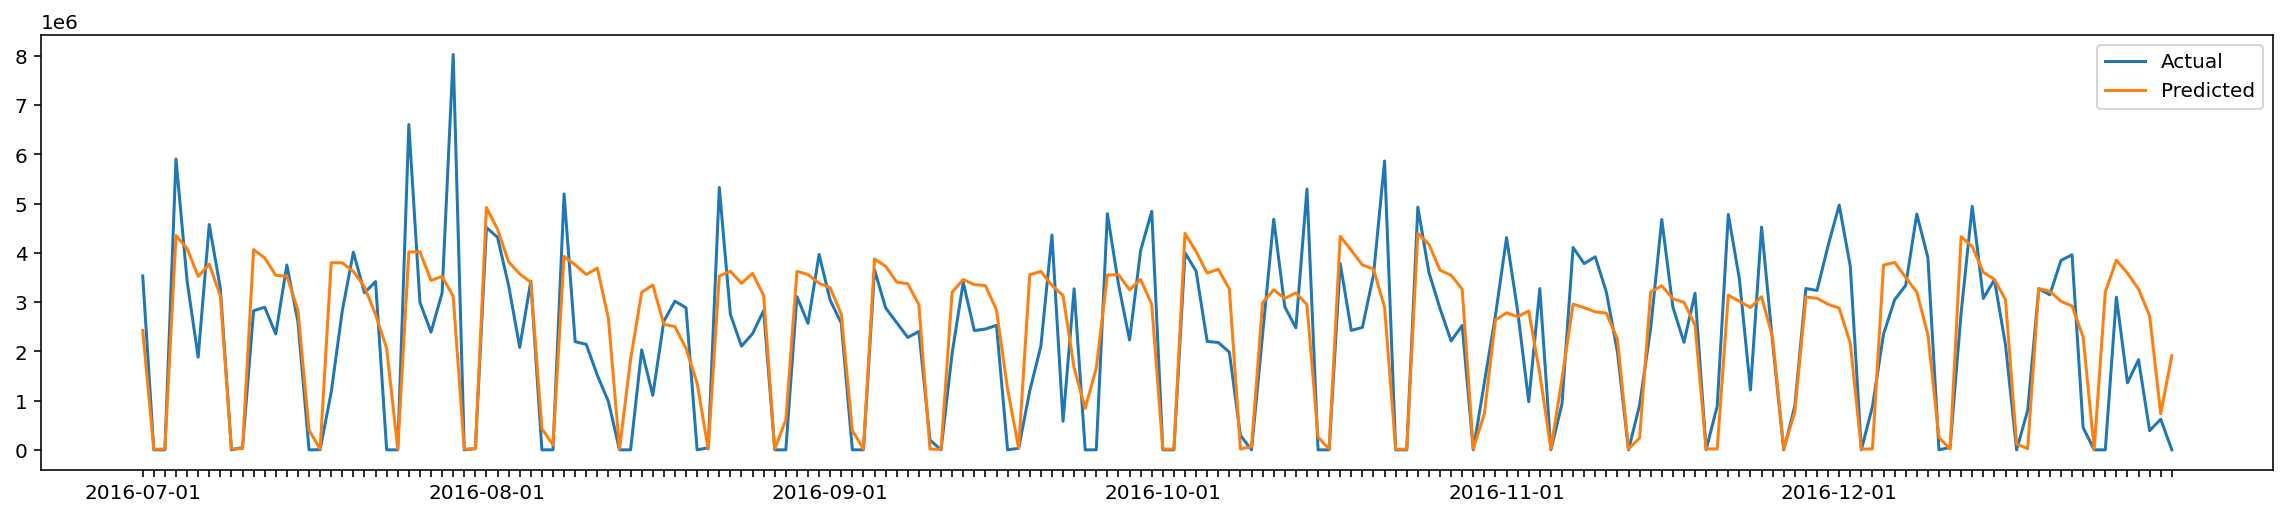

In [61]:
# 결과 시각화
plt.figure(figsize=(20, 4))
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], cat_19[cat_19['date'] >= '2016-07-01']['order_demand'], label='Actual')
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], y_pred, label='Predicted')

labels = [item if item[-2:] == '01' else '' for item in sorted(day_list) if ((item[:4] == '2016') and (item[5:7] >= '07'))]
plt.xticks(cat_19[cat_19['date'] >= '2016-07-01']['date'], labels)
plt.legend()

plt.show();

하이퍼 파라미터 튜닝 전 모델의 validation data set에 대한 mae는 약 1,194,299이고, rmse는 약 1,471,630이었다. 하이퍼 파라미터 튜닝 후 mae는 약 842,660이고, rmse 약 1,148,008로 감소하였다. baseline이었던 ARIMA 모델의 mae(약 1,566,822)와 rmse(약 2,036,131)보다 작기 때문에 의미있는 모델이라고 할 수 있다. 하지만 XGBoost를 사용해서 만든 모델의 성능(mae가 약 669,592, rmse 약 999,821)에는 미치지 못한다.

In [62]:
# 모델 저장
reg.model.save('LSTM_fine_tunned_22.h5')